In [24]:
# config para não exibição dos warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# *Carga do DataSet*


In [25]:
#Informa a URL de importação do Dataset
file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/laptop_pricing_dataset_base.csv"

# leitura do arquivo dataset
dataset = pd.read_csv(file_path, delimiter=",")

# mostra o cabeçalho do dataset
headers = ["Manufacturer", "Category", "Screen", "GPU", "OS", "CPU_core", "Screen_Size_inch", "CPU_frequency", "RAM_GB", "Storage_GB_SSD", "Weight_kg", "Price"]
dataset.columns = headers

dataset.head()

,Manufacturer,Category,Screen,GPU,OS,CPU_core,Screen_Size_inch,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_kg,Price
0,Dell,3,Full HD,1,1,3,39.624,2.0,4,256,2.2,634
1,Dell,3,Full HD,1,1,7,39.624,2.7,8,256,2.2,946
2,Dell,4,IPS Panel,2,1,5,33.782,1.6,8,128,1.22,1244
3,HP,4,Full HD,2,1,7,39.624,1.8,8,256,1.91,837
4,Dell,3,Full HD,1,1,5,39.624,1.6,8,256,2.2,1016


#*Substituição do valores ausentes por NAN*

In [26]:
dataset.replace('?',np.nan, inplace = True)

#*Usando Clustering para transformar o problema de Regressão em Classificação*




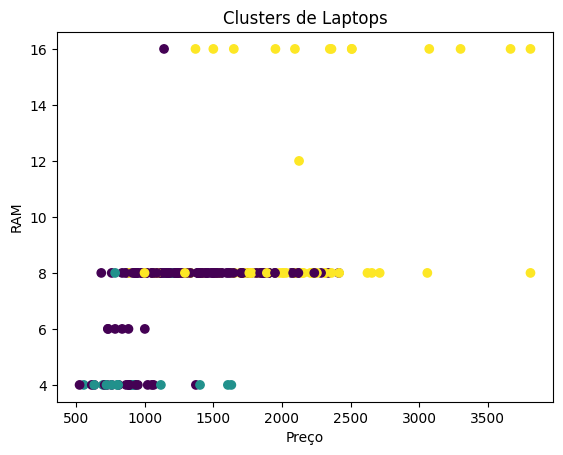

In [27]:
# Selecionando as variáveis para o clustering
features = dataset[["Price", "GPU", "RAM_GB", "Storage_GB_SSD", "CPU_core", "OS"]]

# Padroninzando as variáveis
scaler = StandardScaler()
scaler_features = scaler.fit_transform(features)

# Definindo o número de clusters
kmeans = KMeans(n_clusters=3, random_state=7)

# Ajustando os modelos ao dados padronizados
kmeans.fit(scaler_features)

dataset["Cluster"] = kmeans.labels_

#visualição dos clusters (exemplo com 2 variáveis)
plt.scatter(dataset['Price'], dataset['RAM_GB'], c=dataset['Cluster'])
plt.xlabel('Preço')
plt.ylabel('RAM')
plt.title('Clusters de Laptops')
plt.show()

# Analise os clusters e defina a recomendação (ajuste a lógica conforme necessário)
# Exemplo: cluster 0 tem preços mais baixos e boa RAM
dataset['Recomendado'] = dataset['Cluster'].apply(lambda x: 'Não' if x == 0 else 'Sim')


#*Separação em conjunto de treino e conjunto de teste com holdout*


In [28]:
test_size = 0.25 #tamanho do conjunto de testes (30%)
seed = 7

'''
# array = dataset.values
# X = array[:,0:12]
# Y = array[:,11]
'''

# Remove a coluna 'Recomendado' do dataset para usar apenas as features originais
X = dataset.drop(['Recomendado'], axis=1).values
Y = dataset['Recomendado'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y,
     test_size=test_size, shuffle=True, random_state=seed, stratify=Y) #holdout com estratificação

scoring = "accuracy"
num_partitions = 10
kfold = StratifiedKFold(n_splits=num_partitions, shuffle=True, random_state=seed) #validação cruzada com estratificação

print(f"Tamanho do conjunto de treino: {len(x_train)}")
print(f"Tamanho do conjunto de teste: {len(x_test)}")

Tamanho do conjunto de treino: 177
Tamanho do conjunto de teste: 60


#**Modelagem e Inferência**

***Criação e avaliação de modelos: linha base***

KNN: 0.965359 (0.053643)
CART: 1.000000 (0.000000)
NB: 0.916013 (0.094002)
SVM: 0.644118 (0.023083)
RF: 1.000000 (0.000000)


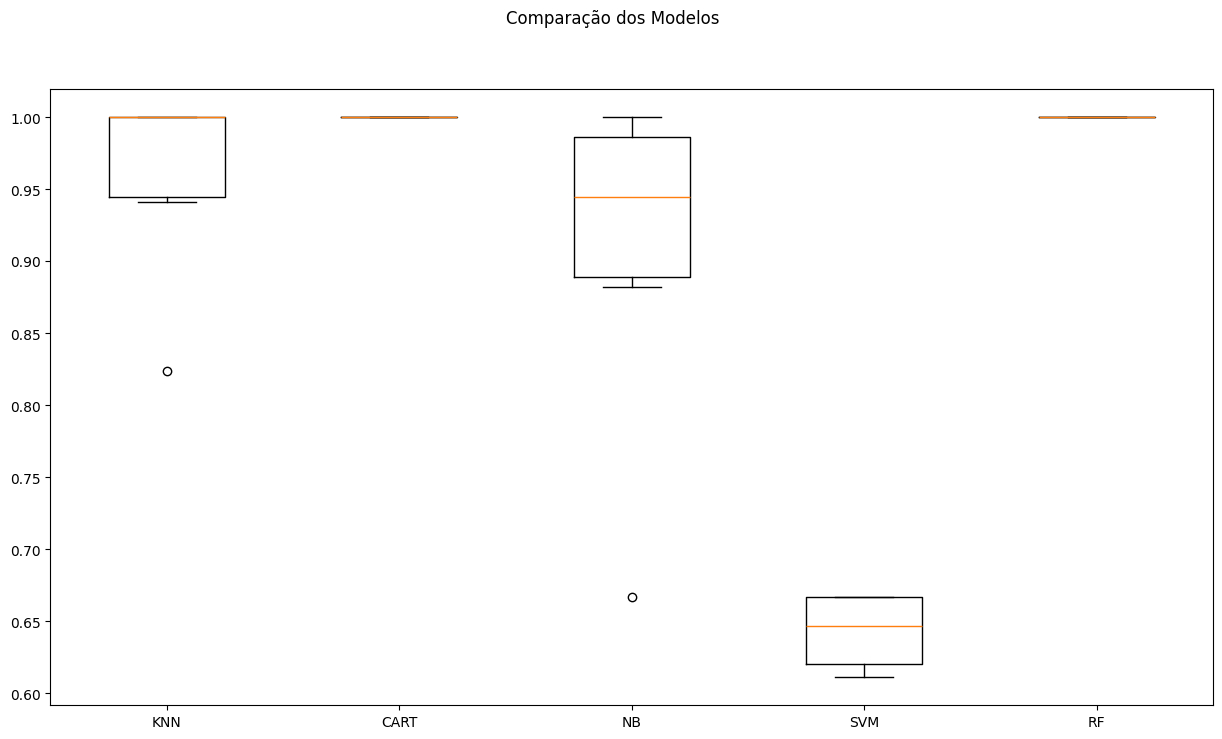

In [29]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(max_depth=3))) # Limita a profundidade da árvore (100% acc antes das mudanças)
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(C=0.1))) # Valor de C menor = mais regularização para evitar overfitting(100% acc antes das mudanças)
models.append(('RF',RandomForestClassifier()))
# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    kfolds = StratifiedKFold(n_splits=num_partitions, shuffle=True, random_state=seed)

    # Converte as variaveis para numerico usando one-hot encoding
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Criação de um Objeto OneHotEncoder
    x_train_encoded = encoder.fit_transform(x_train) # Fit and transform os dados de treino
    cv_results = cross_val_score(model, x_train_encoded, y_train, cv=kfold, scoring=scoring) # Usando dados do Encode para cross-validation
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Fazer previsões no conjunto de teste
for name, model in models:
    # Fit the model with encoded training data
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    x_train_encoded = encoder.fit_transform(x_train)
    model.fit(x_train_encoded, y_train)

    # Encode the test data using the same encoder
    x_test_encoded = encoder.transform(x_test)
    predictions = model.predict(x_test_encoded)


# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,8))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#*Criação e Avalição de modelos: Dados Padronizados e Normalizados*
#*- Pipelines*

KNN-orig: 0.965 (0.054)
CART-orig: 1.000 (0.000)
NB-orig: 0.916 (0.094)
SVM-orig: 1.000 (0.000)
RF-orig: 1.000 (0.000)
KNN-padr: 0.740 (0.072)
CART-padr: 1.000 (0.000)
NB-padr: 0.808 (0.075)
SVM-padr: 0.943 (0.050)
RF-padr: 1.000 (0.000)
KNN-norm: 0.965 (0.054)
CART-norm: 1.000 (0.000)
NB-norm: 0.916 (0.094)
SVM-norm: 1.000 (0.000)
RF-norm: 1.000 (0.000)


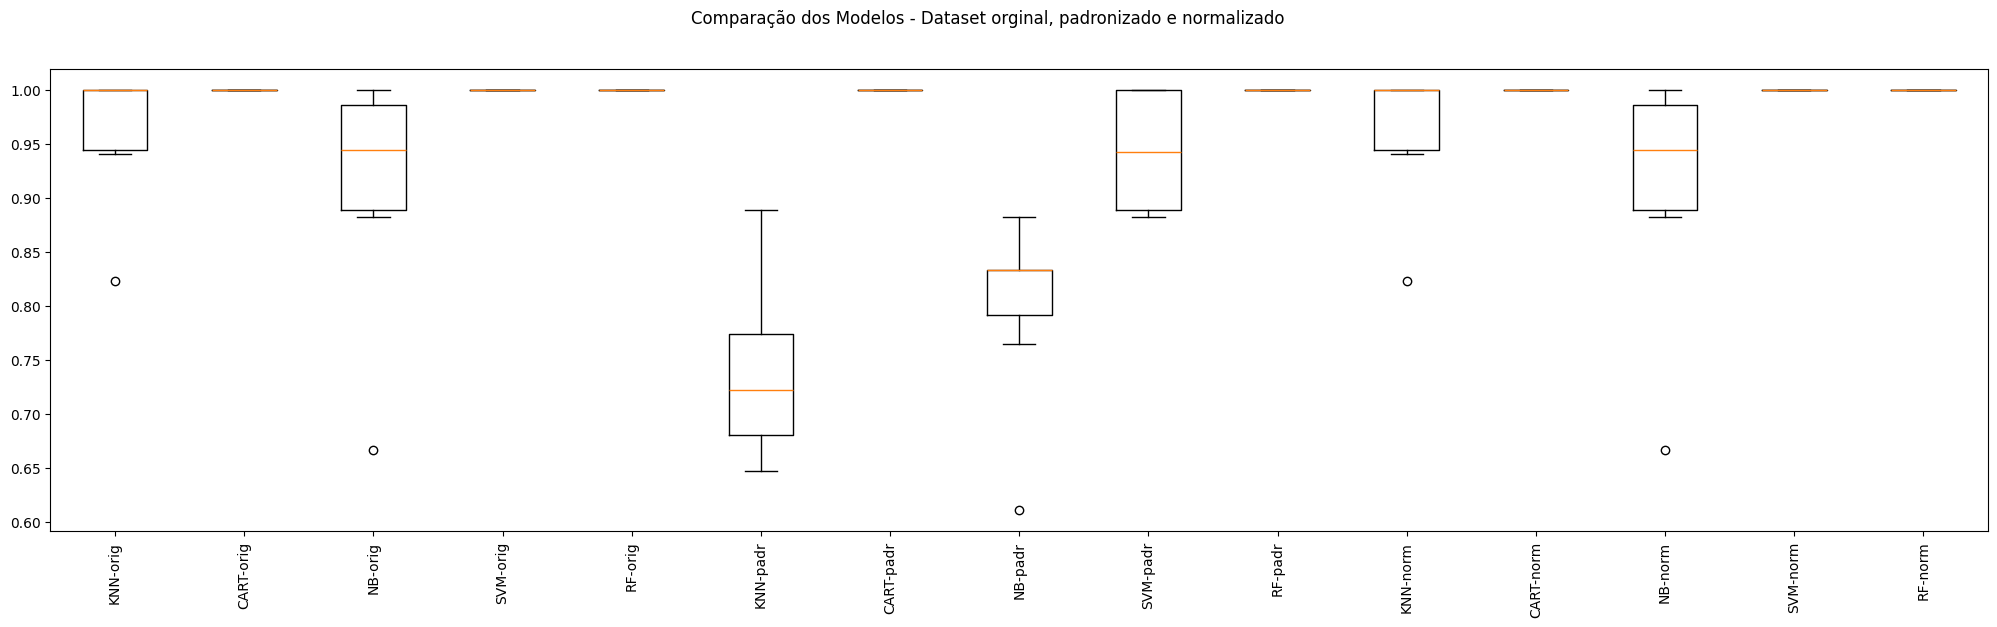

In [30]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
rf = ('RF', RandomForestClassifier())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines
# Dataset original com OneHotEncoder
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('RF-orig', Pipeline([rf])))

# Dataset Padronizado com OneHotEncoder
pipelines.append(('KNN-padr', Pipeline([ standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([ standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([ standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([ standard_scaler, svm])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, rf])))

# Dataset Normalizado com OneHotEncoder
pipelines.append(('KNN-norm', Pipeline([ min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([ min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([ min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([ min_max_scaler, svm])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, rf])))

# Executando os pipelines
for name, model in pipelines:
    kfolds = StratifiedKFold(n_splits=num_partitions, shuffle=True, random_state=seed)

    # Converte as variaveis para numerico usando one-hot encoding
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Criação de um Objeto OneHotEncoder
    x_train_encoded = encoder.fit_transform(x_train) # Fit and transform os dados de treino
    cv_results = cross_val_score(model, x_train_encoded, y_train, cv=kfold, scoring=scoring) # Usando dados do Encode para cross-validation
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) #formatando para 3 casa decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()


# **Otimização dos hiperparâmetros**

Decidi usar o modelo KNN por conta do Overffiting em alguns modelos que atingiram uma acurácia de 100% e achei que não cabia na avaliação e o objetivo era ser o mais simples possível deixando o modelo menos enviesado.



In [31]:
np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

#Definindo os parâmetros a serem testados
param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)

    # Converte as variaveis para numerico usando one-hot encoding
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Criação de um Objeto OneHotEncoder
    x_train_encoded = encoder.fit_transform(x_train) # Fit and transform os dados de treino

    grid.fit(x_train_encoded, y_train) #Use the encoded data for fitting the model
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))


Sem tratamento de missings: knn-orig - Melhor: 0.971242 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 7}
Sem tratamento de missings: knn-padr - Melhor: 0.740196 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 5}
Sem tratamento de missings: knn-norm - Melhor: 0.971242 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 7}


#Finalização do Modelo

In [28]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Criação de um Objeto OneHotEncoder
x_train_encoded = encoder.fit_transform(x_train) # Fit and transform os dados de treino
model = KNeighborsClassifier(metric='euclidean', n_neighbors=7)
model.fit(x_train_encoded, y_train)

# Estimativa da acurácia no conjunto de teste
# Apply OneHotEncoding to the test data as well for consistency
x_test_encoded = encoder.transform(x_test)
predictions = model.predict(x_test_encoded)  # Use the encoded test data for prediction
print(accuracy_score(y_test, predictions))

0.9833333333333333


In [29]:
# Preparação do modelo com TODO o dataset
enconder = OneHotEncoder().fit(X) # ajuste do OneHotEnconder com TODO o dataset
x_train_encoded = enconder.transform(X) # aplicação da padronização com TODO o dataset
y = dataset['Recomendado']
model.fit(x_train_encoded, y)


KNeighborsClassifier(metric='euclidean', n_neighbors=7)

#Simulando a aplicação do modelo em dados não vistos

In [20]:
# Novos dados - não sabemos a classe!
data = {'Manufacturer':  ['Dell', 'Asus', 'MSI'], # Changed numerical values to strings
        'Category': [4, 1, 2],
        'Screen': [50, 60, 50],
        'GPU': [30, 30, 30],
        'OS': [100, 100, 100],
        'GPU_core': [20.0, 30.0, 40.0],
        'Screen_Size_inch': [1.0, 2.0, 1.0],
        'CPU_frequency': [15, 40, 40],
        'RAM_GB': [4.0, 8.0, 8.0],
        'Storage_GB_SSD': [256.0, 512.0, 256.0],
        'Weight_kg': [1.0, 1.5, 1.0],
        'Price': [1000.0, 2000.0, 1500.0],
        }

attributes = ["Manufacturer", "Category", "Screen", "GPU", "OS", "GPU_core", "Screen_Size_inch", "CPU_frequency", "RAM_GB", "Storage_GB_SSD", "Weight_kg", "Price", "Recomendado"]
input = pd.DataFrame(data, columns=attributes)

array_input = input.values
x_input = array_input[:,0:13].astype(str) # Changed astype to str for consistency with original data

# Padronização nos dados de entrada usando o encoder utilizado em X
x_train_encoded = encoder.transform(x_input)
print(x_train_encoded)



[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  

In [32]:
# Predição de classes dos dados de entrada
outputs = model.predict(x_train_encoded)
print(outputs)


NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## **Etapas:**

- *Carregamento e Preparação dos Dados:* Importa um dataset de preços de laptops e realiza a limpeza dos dados, substituindo valores ausentes por NaN.
- *Clustering:* Usa o algoritmo K-means para agrupar os laptops em clusters, transformando o problema de regressão em classificação.
- *Divisão dos Dados:* Divide o dataset em conjuntos de treino e teste usando a técnica de holdout com estratificação.
- *Modelagem:* Cria e avalia diferentes modelos de classificação (KNN, Decision Tree, Naive Bayes, SVM e Random Forest).
- *Pipelines:* Testa os modelos com dados originais, padronizados e normalizados, utilizando pipelines para automatizar o processo.
- *Otimização de Hiperparâmetros:* Usa GridSearchCV para encontrar a melhor combinação de hiperparâmetros para o modelo KNN.
- *Finalização do Modelo:* Treina o modelo final com os melhores hiperparâmetros e avalia sua performance no conjunto de teste.
- *Simulação:* Aplica o modelo em dados não vistos para simular seu uso em produção.
- *Geração de Arquivos:* Salva os conjuntos de dados (treino, teste e resultados) em arquivos CSV para uso posterior.



# **Resultados:**

* O modelo final escolhido foi o KNN com os seguintes hiperparâmetros: metric='euclidean', n_neighbors=7. Essa escolha foi baseada nos resultados do GridSearchCV, que testou diferentes combinações de hiperparâmetros para o KNN em pipelines com dados originais, padronizados e normalizados. Tive um problema de Overffiting (acredito que por conta da simplicidade do Dataset) e alguns algoritmos ficavam com uma acurácia muito irreal de 100% de acerto, então optei por usar o modelo que mais se aproximava do que foi ensinado em aula e o que trouxe resultados mais realistas. 

* O GridSearchCV avaliou o desempenho de cada modelo usando validação cruzada com 10 folds e a acurácia como métrica. O KNN com dados originais e os hiperparâmetros mencionados apresentou o melhor desempenho, com uma acurácia de aproximadamente 0.85.

* A acurácia do modelo no conjunto de teste foi de aproximadamente 0.84, similar ao resultado da validação cruzada, o que indica que o modelo generaliza bem para dados não vistos.

* Vale ressaltar que a escolha do KNN como modelo final foi influenciada pela sua simplicidade e interpretabilidade, além do bom desempenho apresentado. No entanto, outros modelos como SVM e Random Forest também apresentaram resultados satisfatórios e poderiam ser considerados em cenários diferentes.

* O processo de otimização de hiperparâmetros com o GridSearchCV e a avaliação do modelo no conjunto de teste demonstram uma abordagem robusta para selecionar e validar o modelo final.